In [1]:
# the packages
import pandas as pd
import numpy as np
import networkx as nx

# import my own helper functions
from read import read_sims_result
from clean import cleanup_0IR_exp
from clean import cleanup_network

# Page Rank
from networkx.algorithms.link_analysis.pagerank_alg import pagerank, pagerank_numpy, pagerank_scipy

# distance
from networkx.algorithms.shortest_paths.generic import shortest_path_length

# logistic regression
from sklearn.linear_model import LogisticRegression

# plot
import matplotlib.pyplot as plt

In [2]:
# ###########################
# Read OIR results, and fit the model
# ###########################
df0 = read_sims_result("/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/data/0622/0IR300s", 32)
df0c = cleanup_0IR_exp(df0, numNode=32, numPeriod=15, numSim=100, balanced=True)

X = df0c[["deposits", "cash", "assets", "credit available", "wealth", "leverage", 
         "dummy-0-leverage",
         "wealth-lag", "deposits-lag", "cash-lag", "assets-lag", "leverage-lag", 
         "credit-available-lag", "credit-issued-lag", "dummy-0-leverage-lag",
         "over-leverage-frequency"]]
y = df0c["default-next"]

final = LogisticRegression(penalty="l1", C=0.007)
final.fit(X,y)

LogisticRegression(C=0.007, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [3]:
# make sure no defaults in 0IR
# sum(df0[df0["defaults due to interest"]
#     +df0["defaults due to negative wealth"]
#     +df0["defaults due to deposit shock"] == 0].loc[:,"dot0":"dot30"].values)

In [4]:
# ###########################
# Read & process positive IR results
# ###########################
df_1 = read_sims_result("/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/data/0625/1IR", 32)
mx_1n = cleanup_network(df_1, numNode=32, numPeriod=15, numSim=50)
df_1c = cleanup_0IR_exp(df_1, numNode=32, numPeriod=15, numSim=50)

In [5]:
def dist_avg_max(N):
    """
    calculate average & max distances between all pair of nodes
    
    Parameters
    ----------
    N: 4D numpy array [n_simulations, n_periods, n_borrowers, n_lenders]
        debt adjacency matrices 
    
    Returns
    ----------
    avg_d: 2D numpy array [n_simulations, n_periods]
        average distances between all pair of nodes
    max_d: 2D numpy array [n_simulations, n_periods]
        max distances between all pair of nodes
    """
    numSim, numPeriod, _, _ = N.shape
    avg_d = np.empty((numSim, numPeriod-2))
    max_d = np.empty((numSim, numPeriod-2))
    
    for s in range(numSim):
        for p in range(1,numPeriod-1):
            disG = nx.DiGraph(N[s,p])
            dists = shortest_path_length(disG, weight=None)
            curlist=[]
            for source in dists:
                curlist.extend(source[1].values())
            avg_d[s,p-1] = sum(curlist) / float(len(curlist))
            max_d[s,p-1] = max(curlist)
            
    return avg_d, max_d

In [7]:
avgg, maxx = dist_avg_max(mx_1n)

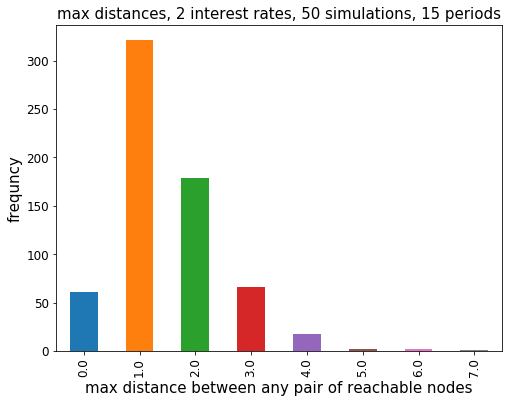

In [9]:
pavg = pd.DataFrame(avgg)
pmax = pd.DataFrame(maxx)
# pavg.mean().plot()
abc = pmax.stack().value_counts().sort_index().plot(
    kind="bar",
    title="max distances, 1 interest rates, 50 simulations, 15 periods",
    figsize=(8,6),
    fontsize=12
)
abc.set_xlabel("max distance between any pair of reachable nodes")
abc.set_ylabel("frequncy")
abc.title.set_fontsize(15)
abc.xaxis.label.set_fontsize(15)
abc.yaxis.label.set_fontsize(15)

In [80]:
# df_1c[df_1c["wealth"]<0].loc[:,"period":]

In [7]:
# df_1.loc[95, "dot30":]

In [8]:
# independent variables
independent = ["deposits", "cash", "assets", "credit available", "wealth", "leverage", 
         "dummy-0-leverage",
         "wealth-lag", "deposits-lag", "cash-lag", "assets-lag", "leverage-lag", 
         "credit-available-lag", "credit-issued-lag", "dummy-0-leverage-lag",
         "over-leverage-frequency"]

In [6]:
def weigh_networks(N, model, variables):
    """
    Add weight to network
    Each debt is multiplied by lenders' predicted default probability
    
    Parameters
    ----------
    N: 4D numpy array [n_simulations, n_periods, n_borrowers, n_lenders]
        debt adjacency matrices 
    model: scikit learn LogisticRegression
        model for default probability
    variables: a list of strings
        independent variables for the model
    
    Returns
    ----------
    WN: 4D numpy array [n_simulations, n_periods, n_borrowers, n_lenders]
        new weighted debt adjacency matrices
    """
    
    WN = np.copy(N)
    simNum, periodNum, bankNum, _= N.shape
    
    for s in range(simNum):
        for p in range(1,periodNum-1):
            for b in range(bankNum):
                X = df_1c[np.array(df_1c["sim#"]==s) &
                          np.array(df_1c["period"]==p) & 
                          np.array(df_1c["bankID"]==b)
                         ][variables].values
                if X.any():
                    predicted_default_probability = model.predict_proba(X)[0][1]
                    WN[s, p-1, b] *= predicted_default_probability
                    
    return WN

In [46]:
def my_pagerank_numpy(G, alpha=0.85, personalization=None, weight='weight', dangling=None):
    """
    This is basically pagerank_numpy without normalization.
    """
    from networkx.algorithms.link_analysis.pagerank_alg import google_matrix
    
    if len(G) == 0:
        return {}
    M = google_matrix(G, alpha, personalization=personalization,
                      weight=weight, dangling=dangling)
    # use numpy LAPACK solver
    eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = np.argmax(eigenvalues)
    # eigenvector of largest eigenvalue is at ind
    largest = np.array(eigenvectors[:, ind]).flatten().real
    return dict(zip(G, map(float, abs(largest))))

In [8]:
def apply_to_networks(f, N):
    """
    Calculate Page Rank scores for all the networks 
    
    Parameters
    ----------
    f: function (2D numpy array -> matrix)
        the function to apply to each network (e.g. Page Rank)
    N: 4D numpy array [n_simulations, n_periods, n_borrowers, n_lenders]
        debt adjacency matrices (netowrks)
    
    Returns
    ----------
    PG: 3D numpy array [n_simulations, n_periods, n_banks]
        Page Rank scores
    """
    
    simNum, periodNum, bankNum, _= N.shape
    PG = np.empty((simNum, periodNum, bankNum))
    
    for s in range(simNum):
        for p in range(1,periodNum-1):
            PG[s, p] = np.array(list(f(nx.DiGraph(N[s, p])).values()))
            
    return PG

In [9]:
# ###########################
# Let's add the weight
# ###########################
weighted = weigh_networks(mx_1n, final, independent)

In [50]:
# ###########################
# Let's calculate pagerank
# ###########################
pg_iter = apply_to_networks(pagerank, weighted)
pg_norm = apply_to_networks(pagerank_numpy, weighted)
pg_not_norm = apply_to_networks(my_pagerank_numpy, weighted)

In [11]:
# weighted[2,1]

array([[0.        , 0.        , 0.        , 0.55679311, 0.        ,
        0.37119584, 0.31816793, 0.27839699, 0.24746404, 0.22271768,
        0.        , 0.        , 0.17132099, 0.        , 0.14847816,
        0.13919849, 0.13101022, 0.1237318 , 0.11721992, 0.10605583,
        0.09683349, 0.0890869 , 0.08248816, 0.07679927, 0.07184436,
        0.06749007, 0.0636335 , 0.06019385, 0.05710685, 0.10123511,
        0.09279885],
       [0.90888626, 0.        , 0.        , 1.10676712, 0.        ,
        0.73784561, 0.63243922, 0.55338442, 0.49189736, 0.44270771,
        0.        , 0.        , 0.34054379, 0.31621918, 0.2951379 ,
        0.27669221, 0.26041594, 0.02459482, 0.23300424, 0.21081278,
        0.19248105, 0.17708274, 0.16396607, 0.15265798, 0.14280883,
        0.13415359, 0.12648767, 0.1196505 , 0.11351431, 0.20123039,
        0.18446119],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.854701  , 0.732601  , 0.641026  , 0.569801  , 0.512821  ,
      

In [55]:
# print(pg_norm[2,5])
# print(pg_not_norm[2,5])
# print(pg_iter[2,5])

[0.11687229 0.02476124 0.02476124 0.02476124 0.02823983 0.02476124
 0.02476124 0.02476124 0.02476124 0.02476124 0.02476124 0.02729223
 0.02601555 0.02532974 0.02686557 0.02615693 0.02476124 0.02476124
 0.02476124 0.02615299 0.02612805 0.02609152 0.02476124 0.04704637
 0.02476124 0.02590666 0.02476124 0.12516966 0.02579149 0.02476124
 0.02476124]
[0.52470098 0.1111662  0.1111662  0.1111662  0.12678343 0.1111662
 0.1111662  0.1111662  0.1111662  0.1111662  0.1111662  0.12252911
 0.11679742 0.11371847 0.12061363 0.11743215 0.1111662  0.1111662
 0.1111662  0.11741448 0.11730252 0.11713852 0.1111662  0.21121584
 0.1111662  0.11630858 0.1111662  0.56195221 0.11579153 0.1111662
 0.1111662 ]
[0.11687167 0.02476123 0.02476123 0.02476123 0.0282398  0.02476123
 0.02476123 0.02476123 0.02476123 0.02476123 0.02476123 0.0272922
 0.02601552 0.02532972 0.02686554 0.0261569  0.02476123 0.02476123
 0.02476123 0.02615297 0.02612803 0.0260915  0.02476123 0.04704618
 0.02476123 0.02590664 0.02476123 0.1251

In [51]:
list(map(sum, pg_norm[2]))

[2.297e-321,
 0.9999999999999991,
 0.9999999999999996,
 0.9999999999999989,
 0.9999999999999997,
 0.9999999999999996,
 0.9999999999999994,
 0.9999999999999992,
 0.9999999999999994,
 0.9999999999999999,
 1.0,
 0.9999999999999989,
 0.9999999999999999,
 0.9999999999999994,
 2.297e-321]

In [48]:
list(map(sum, pg_not_norm[2]))

[5e-324,
 5.349312795049792,
 5.517578323552296,
 5.387735920975884,
 5.455519363980492,
 4.489524304219675,
 4.256502893411028,
 5.345194283759503,
 4.035284248932143,
 4.820835260660966,
 5.520366540145044,
 4.444792152498667,
 5.41165333853417,
 5.155045966659313,
 5e-324]

In [14]:
pg_not_norm[2]

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         4.94065646e-324,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000],
       [-1.51898196e-001, -1.24603696e-001, -1.24603696e-001,
        -1.87344348e-001, -1.26995493e-001, -2.80087457e-001,
        -2.57875518e-001, -3.64632846e-001, -2.28259598e-001,
        -1.92557201e-001, -1.29085439e-001, -1.24603696e-001,
        -1.96365362e-001, -1.42466610e-001, -1.53579849e-001,
        -1.82910130e-001, -1.79480286e-001,

In [15]:
# G = nx.DiGraph(mx_1n[3,2])
# nx.draw(G)

In [16]:
# opq = {"d":3, 90:"pop"}
# np.array(list(opq.values()))

In [17]:
# pg = pagerank_numpy(G)
# print(type(pg))
# for k,v in pg.items():
#     print("{:<3}| {:.8}".format(k,v))

In [18]:
ddd=nx.DiGraph()
ddd.add_weighted_edges_from([('A','B',0.5),('A','C',0.5)])
print(pagerank_numpy(ddd))
ddd['A']['C']['weight']=1
print(pagerank_numpy(ddd))  

{'A': 0.2597402597402597, 'B': 0.37012987012987014, 'C': 0.37012987012987014}
{'A': 0.2597402597402599, 'B': 0.3333333333333334, 'C': 0.40692640692640686}


In [19]:
mmm = np.array([[0.5,0.05,1],[0,0,0],[1,3,4]])
pdd=nx.DiGraph(mmm)
pdd[0][1]

{'weight': 0.05}